## Сравнение моделей (timm): ResNet18 vs EfficientNet-B0
Этот ноутбук использует уже сохранённые результаты из папок `experiments/**`:
- собирает сводную таблицу из `results.json`,
- выбирает лучшую модель в семействе ResNet и EfficientNet,
- показывает сохранённые графики кривых обучения и `confusion_matrix.png`,
- делает короткий вывод и выбор лучшей модели.


In [5]:
# Сканируем папки с экспериментами и собираем таблицу результатов
from pathlib import Path
import json
import pandas as pd

# Находим корень проекта, даже если ноутбук запущен из папки experiments/
_candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
root = None
for c in _candidates:
    if (c / 'experiments').exists():
        root = c
        break
if root is None:
    root = Path.cwd()

roots_to_scan = [root / 'experiments']
# дополнительно учтём training/experiments, если есть
if (root / 'training' / 'experiments').exists():
    roots_to_scan.append(root / 'training' / 'experiments')

records = []
scanned = []
for base in roots_to_scan:
    scanned.append(str(base.resolve()))
    for res_path in base.rglob('results.json'):
        exp_dir = res_path.parent
        try:
            with open(res_path, 'r', encoding='utf-8') as f:
                res = json.load(f)
        except Exception as e:
            print('Failed to read', res_path, e)
            continue
        model_name = res.get('model_name') or res.get('backbone') or exp_dir.name
        family = 'EfficientNet' if 'efficientnet' in model_name.lower() else ('ResNet' if 'resnet' in model_name.lower() else 'Other')
        test_acc = res.get('test_accuracy') or res.get('metrics', {}).get('test_accuracy')
        val_acc = res.get('best_val_accuracy') or res.get('metrics', {}).get('best_val_accuracy')
        records.append({
            'exp_dir': str(exp_dir),
            'model_name': model_name,
            'family': family,
            'val_accuracy': val_acc,
            'test_accuracy': test_acc,
        })

results_df = pd.DataFrame(records)
if not results_df.empty:
    results_df = results_df.sort_values(by=['family','test_accuracy','val_accuracy'], ascending=[True, False, False]).reset_index(drop=True)
print('Scanned roots:', scanned)
print('Found experiments:', len(results_df))
results_df


Scanned roots: ['C:\\Users\\79673\\OneDrive\\Документы\\учёба\\7 семестр\\ML\\fine-tuning\\experiments']
Found experiments: 2


,exp_dir,model_name,family,val_accuracy,test_accuracy
0,c:\Users\79673\OneDrive\Документы\учёба\7 семе...,efficientnet_b0_efficientnet_b0_experiment_202...,EfficientNet,96.226415,0.966102
1,c:\Users\79673\OneDrive\Документы\учёба\7 семе...,resnet18_resnet18_experiment_20251101_024416,ResNet,98.113208,0.966102


In [6]:
# Выбираем лучшую модель в каждом семействе (ResNet, EfficientNet)
import numpy as np

best_rows = {}
if not results_df.empty:
    for fam in ['ResNet', 'EfficientNet']:
        fam_df = results_df[results_df['family'] == fam]
        if fam_df.empty:
            continue
        fam_df = fam_df.copy()
        fam_df['score'] = fam_df['test_accuracy'].fillna(fam_df['val_accuracy']).astype(float)
        best_rows[fam] = fam_df.sort_values('score', ascending=False).iloc[0]

best_rows


{'ResNet': exp_dir          c:\Users\79673\OneDrive\Документы\учёба\7 семе...
 model_name            resnet18_resnet18_experiment_20251101_024416
 family                                                      ResNet
 val_accuracy                                             98.113208
 test_accuracy                                             0.966102
 score                                                     0.966102
 Name: 1, dtype: object,
 'EfficientNet': exp_dir          c:\Users\79673\OneDrive\Документы\учёба\7 семе...
 model_name       efficientnet_b0_efficientnet_b0_experiment_202...
 family                                                EfficientNet
 val_accuracy                                             96.226415
 test_accuracy                                             0.966102
 score                                                     0.966102
 Name: 0, dtype: object}


=== ResNet | resnet18_resnet18_experiment_20251101_024416 ===
Val acc: 98.11320754716981, Test acc: 0.9661016949152542


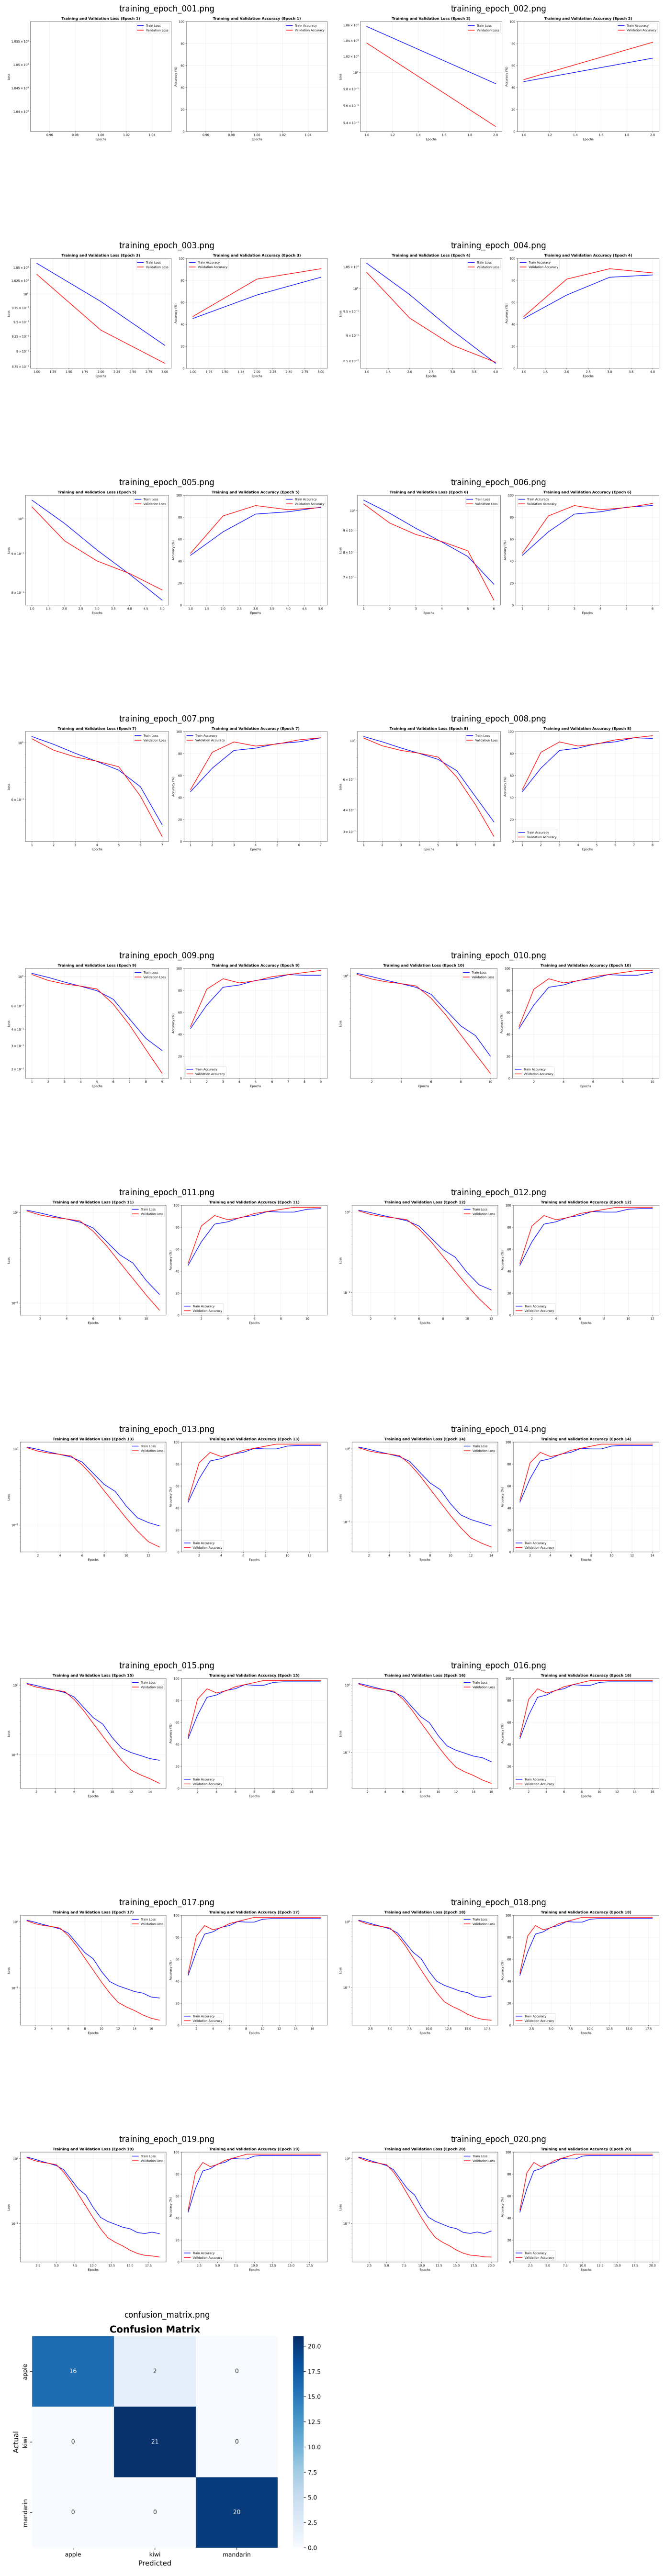


=== EfficientNet | efficientnet_b0_efficientnet_b0_experiment_20251101_030743 ===
Val acc: 96.22641509433963, Test acc: 0.9661016949152542


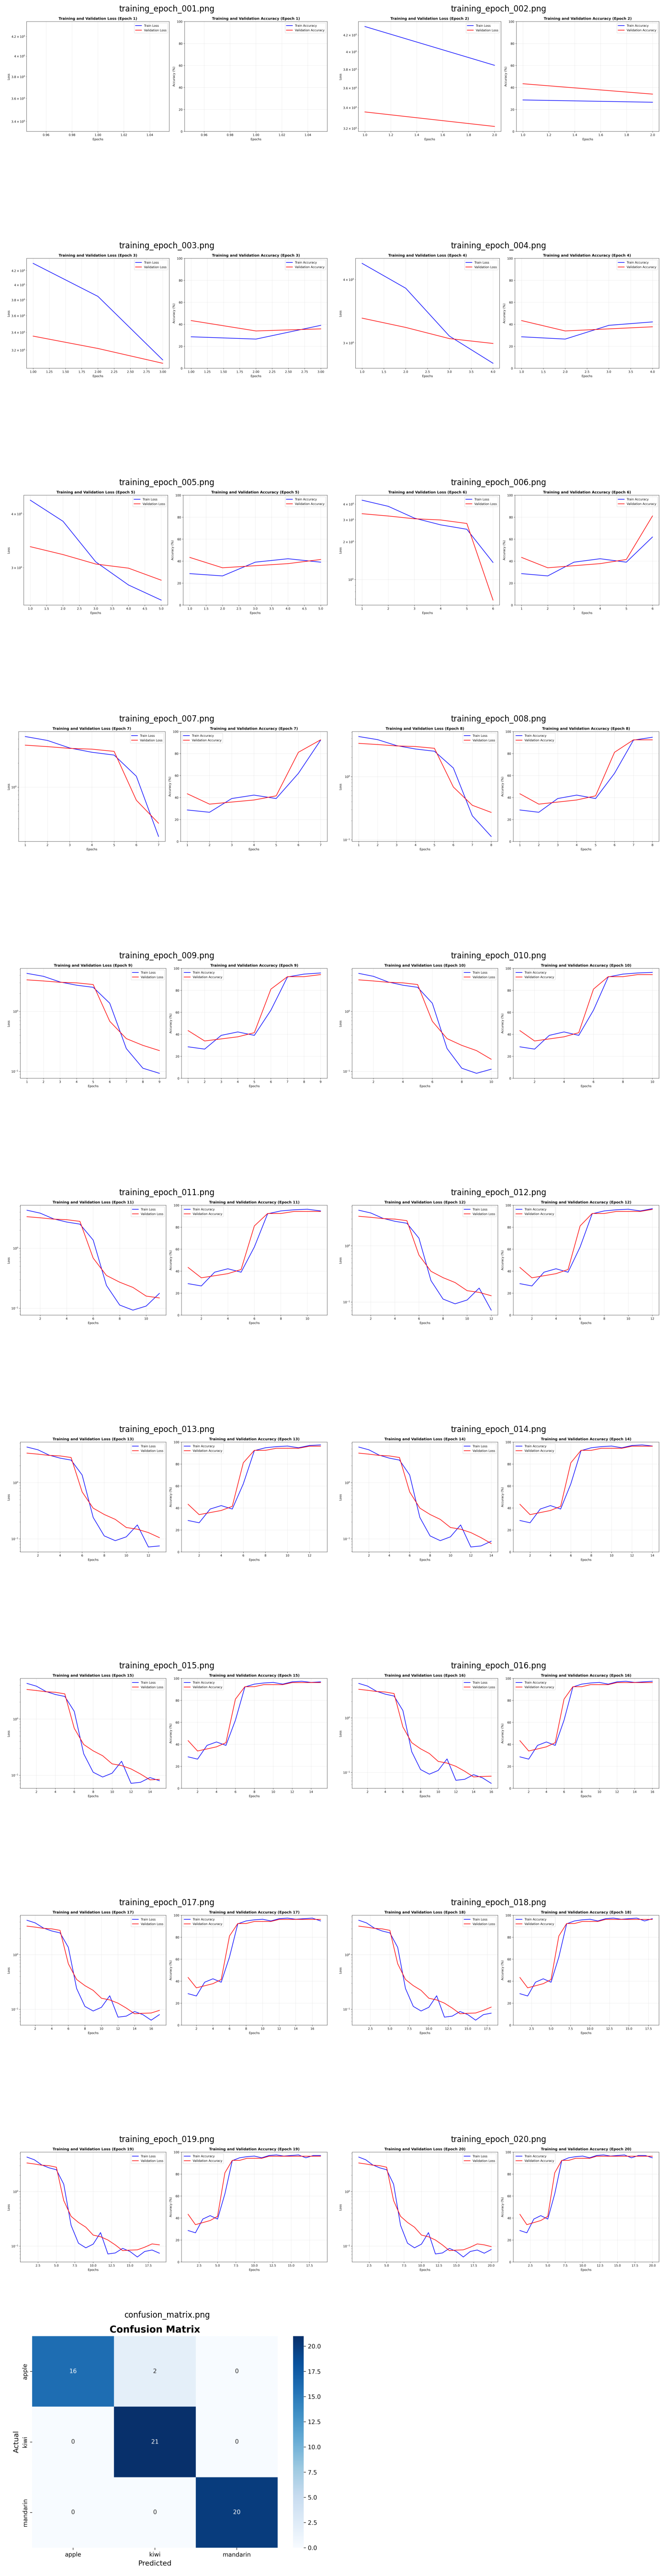

In [7]:
# Отображаем сохранённые графики и confusion matrix для выбранных экспериментов
from IPython.display import display
import matplotlib.pyplot as plt


def display_artifacts(row):
    if row is None:
        return
    from pathlib import Path
    exp_dir = Path(row['exp_dir'])
    print(f"\n=== {row['family']} | {row['model_name']} ===")
    print(f"Val acc: {row['val_accuracy']}, Test acc: {row['test_accuracy']}")

    # Собираем все кадры обучения по эпохам + итоговые артефакты
    epoch_imgs = sorted(exp_dir.glob('training_epoch_*.png'))
    extras = []
    for c in ['training_history.png', 'training_curve.png', 'confusion_matrix.png']:
        p = exp_dir / c
        if p.exists():
            extras.append(p)

    imgs = epoch_imgs + extras
    if not imgs:
        print('No plots found in', exp_dir)
        return

    # Выводим последовательно (в сетке), но включаем все эпохи
    n = len(imgs)
    cols = 2
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(7*cols, 5*rows))
    for i, p in enumerate(imgs, 1):
        img = plt.imread(str(p))
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(p.name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

if best_rows:
    display_artifacts(best_rows.get('ResNet'))
    display_artifacts(best_rows.get('EfficientNet'))
else:
    print('No results found to display.')



### Выбор лучшей модели и краткое обсуждение
- Критерий: `test_accuracy` (если нет — `best_val_accuracy`).
- Если качества близки, выбираем более компактную/быструю модель (обычно EfficientNet-B0);
  при явном преимуществе по качеству — модель-лидер (например, ResNet18).
- Смотрите на динамику кривых (стабильность обучения) и матрицу ошибок (типичные промахи).


In [8]:
# Автоматический выбор лучшей модели между семействами
best_choice = None
if best_rows:
    # Собираем кандидатов
    cand = [r for r in [best_rows.get('ResNet'), best_rows.get('EfficientNet')] if r is not None]
    if cand:
        dfc = pd.DataFrame(cand)
        dfc = dfc.copy()
        dfc['score'] = dfc['test_accuracy'].fillna(dfc['val_accuracy']).astype(float)
        best_choice = dfc.sort_values('score', ascending=False).iloc[0]
        print('Best overall model:')
        display(dfc[['family','model_name','val_accuracy','test_accuracy']])
        print('\n=> SELECTED:', best_choice['family'], '|', best_choice['model_name'],
              '| score =', best_choice['score'])
else:
    print('No candidates to select from.')


Best overall model:


,family,model_name,val_accuracy,test_accuracy
1,ResNet,resnet18_resnet18_experiment_20251101_024416,98.113208,0.966102
0,EfficientNet,efficientnet_b0_efficientnet_b0_experiment_202...,96.226415,0.966102



=> SELECTED: ResNet | resnet18_resnet18_experiment_20251101_024416 | score = 0.9661016949152542
